In [32]:
from KMedoids import KMedoids
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
import os
from collections import defaultdict

# Check KMedoids

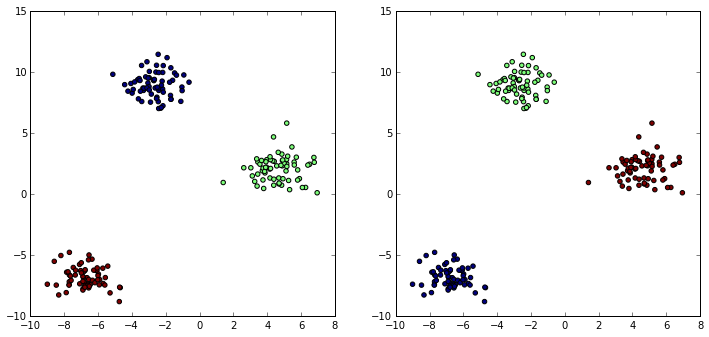

In [2]:
plt.figure(figsize=(12, 12))
n_samples = 200
X, y = make_blobs(n_samples=n_samples, random_state=42)
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y)

#Transform X in a list of bag, each with one instance
Xbag = [x for x in X]
kmedoids = KMedoids(n_clusters=3, random_state=42)
hd_distances = kmedoids.compute_bags_distances(Xbag)
kmedoids.fit(Xbag, hd_distances)
y_pred = kmedoids.predict(Xbag)
plt.subplot(222)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

# Load training data

In [40]:
train_gnet = np.load('../data/models/features/googlenet/train_pool5_7x7_s1.npy')

In [6]:
train_pids = []
with open('../data/train.list', 'r') as lfile:
    for line in lfile:
        _, filename = os.path.split(line)
        pid_str, _ = os.path.splitext(filename)
        train_pids.append(int(pid_str))

In [7]:
pid_to_index = {pid: i for i, pid in enumerate(train_pids)}

In [9]:
assert(len(train_pids) == gnet_all.shape[0])

In [16]:
train_bid_to_labels_df = pd.read_csv('../data/raw/train.csv')
train_pid_to_bid_df = pd.read_csv('../data/raw/train_photo_to_biz_ids.csv')
train_bid_to_labels_df = train_bid_to_labels_df.dropna()

In [13]:
def binarize(labels_str, size=9):
    labels = [int(l) for l in labels_str.split()]
    binary_labels = np.zeros((9,))
    for l in labels:
        binary_labels[l] = 1
    return binary_labels

In [18]:
binarize('1 4 7')

array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.])

In [29]:
bid_to_labels_str = dict(zip(train_bid_to_labels_df.business_id, train_bid_to_labels_df['labels']))

In [30]:
bid_to_labels = {bid: binarize(labels) for bid, labels in bid_to_labels_str.items()}

In [35]:
train_pid_to_bid = dict(zip(train_pid_to_bid_df.photo_id, train_pid_to_bid_df.business_id))

In [37]:
bid_to_pids = defaultdict(list)
for pid, bid in train_pid_to_bid.items():
    if pid in pid_to_index and bid in bid_to_labels:
        bid_to_pids[bid].append(pid)

## Create bag-of-instances

In [41]:
X = []
for bid, pids in bid_to_pids.items():
    indices = np.array([pid_to_index[pid] for pid in pids])
    X.append(train_gnet[indices])

In [42]:
len(X)

1996

# Compute all bag-to-bag Haussdorf distances

In [48]:
kmedoids = KMedoids(n_clusters=10)

In [ ]:
hd_distances = kmedoids.compute_bags_distances(X)

In [ ]:
np.save('hd_distances.npy', hd_distances)

In [ ]:
hd_distances.shape

# Define training procedure on reduced data

In [ ]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

In [ ]:
def fit(X):
    n_labels = 9
    best_Cs = np.zeros((n_labels, ))
    best_f1s = np.zeros((n_labels, ))
    best_thresholds = np.zeros((n_labels, ))
    Cs = np.logspace(-4, 1, num=10)
    thresholds = np.linspace(0.2, 0.8, 50)

    for att in range(n_labels):
        for C in Cs:
            kfold = KFold(n = X.shape[0], n_folds=4, shuffle=True)

            f1s = [[] for i in range(100)]
            for train_index, test_index in kfold:
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index, att], y[test_index, att]

                scaler = StandardScaler()
                X_train_s = scaler.fit_transform(X_train)

                clf = LogisticRegression(C=C)
                clf.fit(X_train_s, y_train)

                X_test_s = scaler.transform(X_test)
                y_probas_test = clf.predict_proba(X_test_s)

                for i, threshold in enumerate(thresholds):
                    y_pred_test = np.where(y_probas_test[:, 1] > threshold, 1, 0)
                    f1s[i].append(f1_score(y_test, y_pred_test))

            for i, threshold in enumerate(thresholds):
                f1_mean = np.mean(f1s[i])
                if f1_mean > best_f1s[att]:
                    best_f1s[att] = f1_mean
                    best_Cs[att] = C
                    best_thresholds[att] = threshold

        print("Best for Attribute: {a}, C: {C}, T: {t}, F1-score: {f1}".format(a=att, C=best_Cs[att],\
                t=best_thresholds[att], f1=best_f1s[att]))
    return best_Cs, best_thresholds, best_f1s

In [ ]:
seed = 42
np.random.seed(seed)
perm_bid = np.random.permutation(len(X))
train_ratio = 0.7
train_num = int(len(X) * train_ratio)
train_indices = perm_bid[:train_num]
val_indices = perm_bid[train_num:]

In [ ]:
def subset(X, indices):
    return [x for i, X in enumerate(X) if i in set(indices)]

In [ ]:
X_train = subset(X, train_indices)
X_val = subset(X, val_indices)

In [ ]:
ks = [10, 50, 200]

In [ ]:
train_ids = np.array(train_indices)
train_hd_distances = hd_distances[np.ix_(train_ids, train_ids)]

In [ ]:
grid = []
for k in ks:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    Z_train = kmedoids.fit_transform(X_train, train_hd_distances)
    Z_val = kmedoids.transform(X_val)
    clf = LogisticRegression()
    best_Cs, best_thresholds, best_f1s = fit(Z_train)
    grid.append((best_Cs, best_thresholds, best_f1s))